In [ ]:
from wtlike import *
import numpy as np

# wtlike tutorial

> A step by step guide

### Install `wtlike`

This assumes that you already have a Jupyter Notebook Server configured on your machine. 

`wtlike` is on PyPI

```
pip install wtlike
```
We use a simulated on-the-fly dataset in lieu of downloading the 2-GB file with all of *fermi* data.

### Define a source flux function. 
Note that we measure time in day units, and will pick a 30-day interval for this demo.

The following function has a flare at 15 days.

In [ ]:
def src_flare(t, tzero=15, width=1, amp=5):
    return 1e-6*(1 + amp*np.exp(-(t-tzero)**2/2/width))

We use it to tell the simulation that the flux has this behavior. Note defaults:

- background -- 1e-6 /s
- exposure rate -- 3000 cm^2 

Here we create a `Simulation` object, then pass it to the primary wtlike entry point, the class `WtLike`.
We tell it to immediately bin the photons into daily time-bins, called "cells". (That can be easily redone.)

In [ ]:
test_sim = Simulation('flare_sim', src_flux=src_flare, tstart=0, tstop=30, )
daily = WtLike(test_sim, time_bins=(0,0,1))

generated 18984 photons
SourceData: Source flare_sim with:
	 data:        18,984 simulated photons over 30.0 days.
	 exposure:     8,640 intervals,  average flux 3000 cm^2 for 2.6 Ms
	 rates:  source 1.43e-06/s, background 1.01e-06/s, S/N ratio 1.41e+00
CellData: Bin photon data into 30 1-day bins from 0.0 to 30.0
LightCurve: select 30 cells for fitting with e>5 & n>2


Now make a light curve!

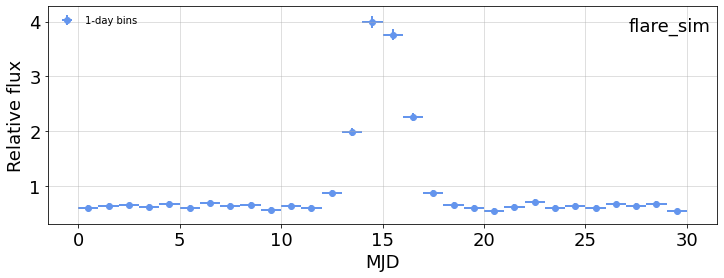

In [ ]:
daily.plot();

The cells have each been analyzed to create a likelihood function representation. The first few cells are:

In [ ]:
daily.cells.head(2)

,t,tw,e,tau,n,w,S,B
0,0.5,1.0,258.3,NaN,540,"[0.015607219, 0.40574607, 0.79659104, 0.255918...",368.47,262.13
1,1.5,1.0,259.2,NaN,566,"[0.11285197, 0.70598906, 0.80633116, 0.0010050...",369.76,263.04


The Kerr likelihood function for a cell is a function of $w$, the list of weights, and $S$, an estimate for the total signal counts in the cell

$$ \displaystyle\log\mathcal{L}(\alpha\ |\ w)\ = \sum_{w}  \log \big( 1 + \alpha\ w \big) - \alpha\ S  $$

where $\alpha$ is the variation from the nominal zero. The background is assumed to be constant here, as it usually is the region surrounding sources of interest. 
The relative flux is $1+\alpha$. 

We generate an approximate representation of this function by fitting it to a 3-parameter Poisson-like function, which easily provides the values of interest.

In [ ]:
daily.fluxes.head(2)

,t,tw,n,e,ts,flux,errors,limit
0,0.5,1.0,540,258.3,352.6,0.61,"(-0.049, 0.05)",0.69
1,1.5,1.0,566,259.2,389.2,0.64,"(-0.05, 0.051)",0.73


Note that the properties `photons`, `exposure`, `cells`, `fits`, and `fluxes` are [DataFrames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). So we can find a fit at the peak with a `query`.

In [ ]:
daily.fluxes.query('flux>3')

,t,tw,n,e,ts,flux,errors,limit
14,14.5,1.0,1644,259.2,9939.5,3.99,"(-0.105, 0.107)",4.17
15,15.5,1.0,1557,259.2,9257.4,3.76,"(-0.102, 0.104)",3.94


## Views
A `WtLike` object provides a function `view`, which returns a **new** instance with a different binning. 
So if we want a detailed look at the flare, we can choose an interval as so:

CellData: Bin photon data into 40 6-hour bins from 10.0 to 20.0
LightCurve: select 40 cells for fitting with e>5 & n>2


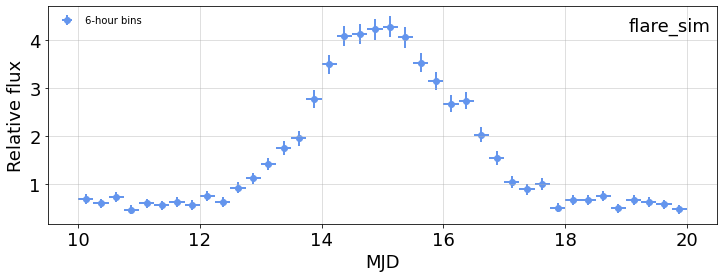

In [ ]:
qday = daily.view((10,-10, 0.25))
qday.plot();

### Bayesian-Block view
The WtLike object also has a special `bb_view` function, which does a Bayesian Block analysis and returns a view of it. 

LightCurve: select 40 cells for fitting with e>5 & n>2
Bayesian Blocks: using penalty 0.05
Partitioned 40 cells into 9 blocks, using LikelihoodFitness 
LightCurve: Loaded 9 / 9 cells for fitting


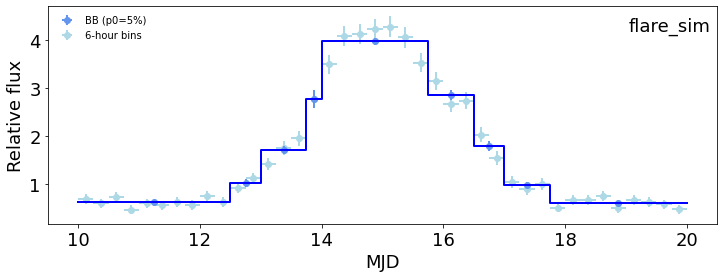

In [ ]:
bb = qday.bb_view();bb.plot();

This creates variable-sized cells corresponding to the Bayesian Block analysis, the fits for which are shown here:

In [ ]:
bb.fluxes

,t,tw,n,e,ts,flux,errors,limit
0,11.25,2.50,1314,64.8,1011.6,0.63,"(-0.031, 0.031)",0.69
1,12.75,0.50,327,64.8,486.4,1.03,"(-0.082, 0.085)",1.18
2,13.38,0.75,628,64.8,1915.5,1.72,"(-0.082, 0.084)",1.86
3,13.88,0.25,312,64.8,1400.2,2.78,"(-0.176, 0.182)",3.10
4,14.88,1.75,2866,64.8,17439.5,3.98,"(-0.079, 0.08)",4.11
5,16.12,0.75,941,64.8,4355.8,2.86,"(-0.104, 0.106)",3.04
6,16.75,0.50,442,64.8,1278.8,1.80,"(-0.103, 0.106)",1.98
7,17.38,0.75,479,64.8,666.0,0.99,"(-0.066, 0.068)",1.10
8,18.88,2.25,1139,64.8,854.0,0.62,"(-0.032, 0.033)",0.67


### Getting help
This jupyterlab environment allows easy exploration of help for any class or function.
The two classes so far:

In [ ]:
Simulation = Simulation
Simulation?

Init signature:
Simulation(
    name,
    src_flux,
    tstart,
    tstop,
    bkg_rate=1e-06,
    efun=3000,
    wt_signif=0.1,
)
Docstring:      <no docstring>
Init docstring:
- src_flux : source flux, scalar or function of days, typically around 1e-7
- tstart, tstop :(days)
- bkg_rate : background flux, scalar or function of day, typicaly 1e-6 for 4-deg cone
- efun : scalar, function (of time in days) of the exposure/s. Typically 3000 cm^2 for fermi

- wt_signif : now the width of the PSF in (r/rmax)**2 coordinates
File:           /mnt/c/users/thbur/OneDrive/work/wtlike/wtlike/simulation.py
Type:           type
Subclasses:     


In [ ]:
WtLike?

Init signature: WtLike(*pars, **kwargs)
Docstring:     
Summary
---------
There are three layers of initialization, implemented in superclasses,
each with parameters. The classnames, associated parameters and data members set:

SourceData -- load photons and exposure
    parameters:
      - source : name, a PointSource object, or a Simulation object
      - config [Config()] : basic configuration
      - week_range [None] : range of weeks to load
      - key [''] : the cache key: '' means construct one with the source name, None to disable
      - clear [False] : if using cache, clear the contents first
    sets:
      - photons
      - exposure

CellData -- create cells
    parameters:
      - time_bins [Config().time_bins] : binning: start, stop, binsize
    sets:
      - cells

LightCurve -- likelihood analysis of the cells
    parameters:
      - e_min [10] -- threshold for exposure (cm^2 units)
      - n_min [2]  -- likelihood has trouble with this few
      - lc_key [None] -- pos

The three WtLike methods have (preliminary) help as well:

In [ ]:
WtLike.plot?

Signature: WtLike.plot(self, *pars, **kwargs)
Docstring:
Make a light curve plot
        Invokes flux_plot, after processing kwargs to intercept
        - log -- translate to `xscale='log'`
        - xlim [None] -- convert to (start, stop) interpreted relative to start, stop if < start.
        - show_flux [False]-- convert y scale to photon flux
        - UTC [False] -- convert x scale to UTC years
-
        Make a plot of flux vs. time. This is invoked by the `plot` function of `LightCurve`

    - cell_fits -- cell fits DataFrame
    - query ['']-- DataFrame query to select subset
    - ts_bar_min -- threshold for plotting as bar vs limit
    - tzero -- time offset, in MJD
    - source_name -- draw text in top left
    - flux_factor [1]

    - ax [None] -- a matplotlib.axes._subplots.AxesSubplot object returned from plt.subplots<br>
    if None, create one using subplots with fignum [1] and figsize [(12,4)]
    - fmt [''] -- marker symbol -- if not specifed, will use '.' if many bins

In [ ]:
WtLike.view?

Signature: WtLike.view(self, *pars, exp_min=None)
Docstring:
Return a "view", a copy of this instance with a perhaps a different set of cells

- pars -- start, stop, step  to define new binning. Or start, step, or just step
   start and stop are either MJD values, or offsets from the start or stop.
   step -- the cell size in days, or if zero, orbit-based binning

- exp_min [None] -- If specified, a different minimum exposure, in cm^2 Ms units to use for fitting
    from.
File:      /mnt/c/users/thbur/OneDrive/work/wtlike/wtlike/cell_data.py
Type:      function


## Using *Fermi* data.

The only change from above is that one uses `PointSource` instead of `Simulation`. 

The data must be available, of course.
So,

In [ ]:
check_data()

Weekly folder "/home/burnett/wtlike_data/data_files" contains 673 weeks.
	 Last week, # 682, has 2.354 days, ends at UTC 2021-06-26 08:51


Get a source: this name can be anything recognized by `astropy.coordinates.SkyCoord`, including all 4FGL sources


In [ ]:
source = PointSource('3C 279'); source

Source "3C 279" at: (l,b)=(305.104,57.062)

This requires access to a packaged form of the photon data, a table allowing generation of weights, and the effective area table.
The source must have been analyzed with `gtlike` or `pointlike` to produce the weight table.
All are available in a 2-GB zip file.

In [ ]:
wtl = WtLike(source)

SourceData: photons and exposure for 3C 279: Restoring from cache with key "P88Y3243_data"
SourceData: Source 3C 279 with:
	 data:       179,086 photons from 2008-08-04 to 2021-06-26
	 exposure: 2,849,429 intervals,  average flux 2846 cm^2 for 85.1 Ms
	 rates:  source 3.93e-07/s, background 3.47e-07/s, S/N ratio 1.13e+00
CellData: Bin photon data into 672 1-week bins from 54683.0 to 59387.0
LightCurve: select 662 cells for fitting with e>5 & n>2


/home/burnett/miniconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


If the the data for this source has not been accessed on this machine before, it must be extracted to a cache, a process that takes some 10 min. Otherwise it is a few seconds to retrieve the cache.

Generate the (default weekly) light curve:

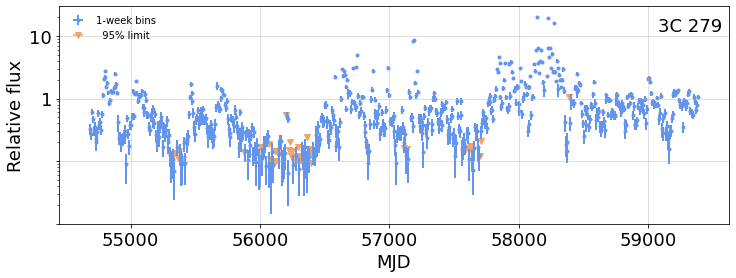

In [ ]:
wtl.plot(log=True, limit_fmt='v');

In [ ]:
wtl.plot?

Signature: wtl.plot(*pars, **kwargs)
Docstring:
Make a light curve plot
        Invokes flux_plot, after processing kwargs to intercept
        - log -- translate to `xscale='log'`
        - xlim [None] -- convert to (start, stop) interpreted relative to start, stop if < start.
        - show_flux [False]-- convert y scale to photon flux
        - UTC [False] -- convert x scale to UTC years
-
        Make a plot of flux vs. time. This is invoked by the `plot` function of `LightCurve`

    - cell_fits -- cell fits DataFrame
    - query ['']-- DataFrame query to select subset
    - ts_bar_min -- threshold for plotting as bar vs limit
    - tzero -- time offset, in MJD
    - source_name -- draw text in top left
    - flux_factor [1]

    - ax [None] -- a matplotlib.axes._subplots.AxesSubplot object returned from plt.subplots<br>
    if None, create one using subplots with fignum [1] and figsize [(12,4)]
    - fmt [''] -- marker symbol -- if not specifed, will use '.' if many bins, else 'o